In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import pickle
import pandas as pd
from IPython.display import Image, display

In [2]:
from keras.preprocessing import image, sequence
from keras.layers import Dense, Convolution2D, Dropout, LSTM, TimeDistributed, Embedding, Bidirectional, Activation, RepeatVector, Merge
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.applications import ResNet50

Using TensorFlow backend.


In [3]:
pd_dataset = pd.read_csv("./Flickr8k_text/flickr_8k_train_dataset.txt", delimiter='\t')
ds = pd_dataset.values
print ds.shape

(30000, 2)


In [4]:
sentences = []
for ix in range(ds.shape[0]):
    sentences.append(ds[ix, 1])
    
print len(sentences)

30000


In [5]:
words = [i.split() for i in sentences]

In [6]:
unique = []
for i in words:
    unique.extend(i)

In [7]:
unique = list(set(unique))
print len(unique)

vocab_size = len(unique)

8253


In [8]:
#Vectorization
word_2_indices = {val:index for index, val in enumerate(unique)}
indices_2_word = {index:val for index, val in enumerate(unique)}

In [9]:
word_2_indices['UNK'] = 0
word_2_indices['raining'] = 8253

indices_2_word[0] = 'UNK'
indices_2_word[8253] = 'raining'

In [10]:
print word_2_indices['<start>']
print indices_2_word[4011]
print word_2_indices['<end>']
print indices_2_word[8051]

4011
<start>
8051
<end>


In [11]:
vocab_size = len(word_2_indices.keys())
print vocab_size

8254


### Model

In [12]:
captions = np.load("./captions.npy")
next_words = np.load("./next_words.npy")

print captions.shape
print next_words.shape

(25493, 40)
(25493, 8254)


In [13]:
images = np.load("./images.npy")

print images.shape

(25493, 2048)


In [14]:
imag = np.load("./image_names.npy")
        
print imag.shape

(25493,)


In [15]:
embedding_size = 128
max_len = 40

In [16]:
image_model = Sequential()

image_model.add(Dense(embedding_size, input_shape=(2048,), activation='relu'))
image_model.add(RepeatVector(max_len))

image_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               262272    
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 40, 128)           0         
Total params: 262,272
Trainable params: 262,272
Non-trainable params: 0
_________________________________________________________________


In [17]:
language_model = Sequential()

language_model.add(Embedding(input_dim=vocab_size, output_dim=embedding_size, input_length=max_len))
language_model.add(LSTM(256, return_sequences=True))
language_model.add(TimeDistributed(Dense(embedding_size)))

language_model.summary()

Instructions for updating:
keep_dims is deprecated, use keepdims instead
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 40, 128)           1056512   
_________________________________________________________________
lstm_1 (LSTM)                (None, 40, 256)           394240    
_________________________________________________________________
time_distributed_1 (TimeDist (None, 40, 128)           32896     
Total params: 1,483,648
Trainable params: 1,483,648
Non-trainable params: 0
_________________________________________________________________


In [18]:
model = Sequential()

model.add(Merge([image_model, language_model], mode='concat', concat_axis=-1))
model.add(LSTM(128, return_sequences=True))
model.add(LSTM(512, return_sequences=False))
model.add(Dense(vocab_size))
model.add(Activation('softmax'))

model.load_weights("./model_weights.h5")
model.compile(loss='categorical_crossentropy', optimizer='RMSprop', metrics=['accuracy'])
model.summary()

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:3: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  This is separate from the ipykernel package so we can avoid doing imports until


Instructions for updating:
keep_dims is deprecated, use keepdims instead
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
merge_1 (Merge)              (None, 40, 256)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 40, 128)           197120    
_________________________________________________________________
lstm_3 (LSTM)                (None, 512)               1312768   
_________________________________________________________________
dense_3 (Dense)              (None, 8254)              4234302   
_________________________________________________________________
activation_1 (Activation)    (None, 8254)              0         
Total params: 7,490,110
Trainable params: 7,490,110
Non-trainable params: 0
_________________________________________________________________


In [19]:
hist = model.fit([images, captions], next_words, batch_size=512, epochs=20)

Epoch 1/20
25493/25493 [==============================] - 128s 5ms/step - loss: 1.6399 - acc: 0.5485
Epoch 2/20
25493/25493 [==============================] - 129s 5ms/step - loss: 1.4462 - acc: 0.5942
Epoch 3/20
25493/25493 [==============================] - 125s 5ms/step - loss: 1.3861 - acc: 0.6060
Epoch 4/20
25493/25493 [==============================] - 132s 5ms/step - loss: 1.3330 - acc: 0.6169
Epoch 5/20
25493/25493 [==============================] - 128s 5ms/step - loss: 1.2890 - acc: 0.6300
Epoch 6/20
25493/25493 [==============================] - 117s 5ms/step - loss: 1.2443 - acc: 0.6371
Epoch 7/20
25493/25493 [==============================] - 117s 5ms/step - loss: 1.2058 - acc: 0.6475
Epoch 8/20
25493/25493 [==============================] - 118s 5ms/step - loss: 1.1751 - acc: 0.6562
Epoch 9/20
25493/25493 [==============================] - 118s 5ms/step - loss: 1.1382 - acc: 0.6662
Epoch 10/20
25493/25493 [==============================] - 118s 5ms/step - loss: 1.0816 - a

In [20]:
model.save_weights("./model_weights.h5")

### Predictions

In [21]:
def preprocessing(img_path):
    im = image.load_img(img_path, target_size=(224,224,3))
    im = image.img_to_array(im)
    im = np.expand_dims(im, axis=0)
    return im

In [22]:
def get_encoding(model, img):
    image = preprocessing(img)
    pred = model.predict(image).reshape(2048)
    return pred

In [23]:
resnet = ResNet50(include_top=False,weights='imagenet',input_shape=(224,224,3),pooling='avg')

In [33]:
img = "./Flickr8k_Dataset/Flicker8k_Dataset/146098876_0d99d7fb98.jpg"

test_img = get_encoding(resnet, img)

In [31]:
def predict_captions(image):
    start_word = ["<start>"]
    while True:
        par_caps = [word_2_indices[i] for i in start_word]
        par_caps = sequence.pad_sequences([par_caps], maxlen=max_len, padding='post')
        preds = model.predict([np.array([image]), np.array(par_caps)])
        word_pred = indices_2_word[np.argmax(preds[0])]
        start_word.append(word_pred)
        
        if word_pred == "<end>" or len(start_word) > max_len:
            break
            
    return ' '.join(start_word[1:-1])

Argmax_Search = predict_captions(test_img)

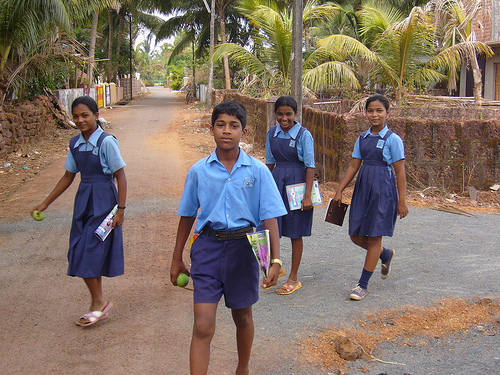

Three women and a man posing on a rural path .


In [34]:
z = Image(filename=img)
display(z)

print (Argmax_Search)